# Transfer Learning: Feature Extraction

In [1]:
import PIL.Image as Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

## 1. Topic

Adapted from a project that was part of the EPFL Extention School's Machine Learning course it is shown how feature extraction works. Different to the EPFL project where tensorflow was directly used to extract the features, keras is considered here. 

There are two different approaches for transfer learning:
1. extract features with the healp of the pre-trained network and create a model on the extracted features.
2. Remove the fully-connected on top of the network, freeze the layers, add some trainable layers on top and train the model.

Here we are focusing on **feature extraction** based on a pre-trained MobileNetV2 model. Other popular models that are used for transfer learning are VGG16, ResNet50 or InceptionV3.

Sources:
- https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/
- https://www.pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/
- https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
- https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
- https://keras.io/guides/transfer_learning/
- https://keras.io/api/applications/mobilenet/
- https://arxiv.org/abs/1801.04381
- https://keras.io/api/applications/

In [2]:
# Load image
def load_image(path, shape=(224,224)):
    """
    
    This function opens an image, reshapes it and returns the reshaped and
    rescaled image.
    
    args:
        path: the relative path to the image
        shape: the shape of the reshaped image
        
    returns:
        the batch of the reshaped image
        
    """
    img = Image.open('./' + path)
    # Create batch for network
    img_resized = img.resize([shape[0], shape[1]], resample=Image.BILINEAR) 
    img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255
    return img_batch

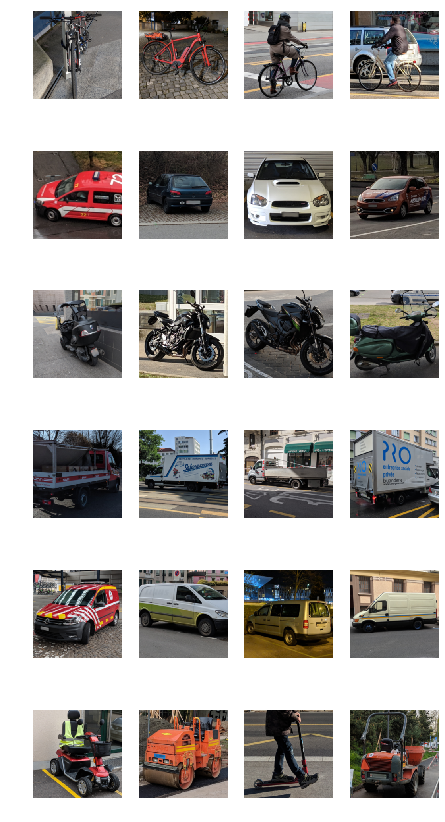

In [3]:
# Load image
categories = ['bike', 'car', 'motorcycle', 'truck', 'van', 'other']
plt.figure(figsize=(15,15))
figs_per_cat = 4 # figures per category
rows = len(categories)

for i, c in enumerate(categories):
    #print(p)
    for j in range(figs_per_cat):
        # 1, 7
        plt.subplot(rows, figs_per_cat, i*figs_per_cat+j+1)
        plt.subplots_adjust(right=0.5)
        path = 'train/' + c + '/' + c + '-' + str(j+1).zfill(4) + '.png'
        #print(path)
        img = load_image(path)
        
        #print('Batch size:', img.shape) # (1, 224, 224, 3)
        plt.imshow(img[0,:,:,:])
        plt.axis('off')

In [4]:
# load model
model = keras.applications.MobileNetV2()

In [5]:
# summarize the model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## 1. Resizing and Rescaling

Batch size: (1, 256, 256, 3)


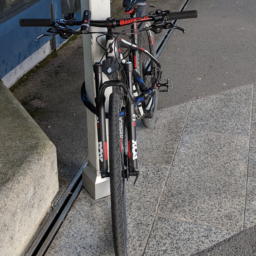

In [6]:
# Load image
img = Image.open('./train/bike/bike-0001.png')
# Create batch for network
img_batch = np.array(img, dtype=np.float32)[np.newaxis, :, :, :]/255
print('Batch size:', img_batch.shape) # (1, 256, 256, 3)
img

Batch size: (1, 224, 224, 3)


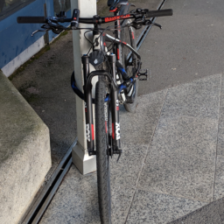

In [7]:
img_resized = img.resize([224, 224], resample=Image.BILINEAR)
img_batch_resized = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255
print('Batch size:', img_batch_resized.shape) # (1, 224, 224, 3)
img_resized

## 2. Feature Extraction (First approach)

### 2.1 Implementation for one Image

We remove the last layer. The second last layer of the original architecture becomes the output layer. This layer has 1280 nodes.

Literature:
- https://keras.io/api/models/model/
- https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

In [8]:
# remove the output layer
model = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [9]:
#model.summary()

In [10]:
features = model.predict(img_batch_resized)
print(features)

[[3.105125   0.37383768 0.3741367  ... 0.         0.14410393 0.81067294]]


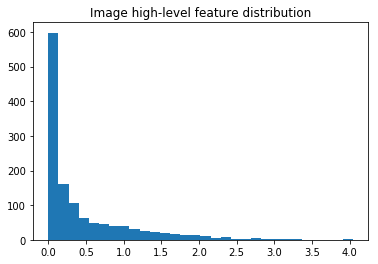

In [11]:
plt.hist(features[0], bins=30)
plt.title('Image high-level feature distribution')
plt.show()

### 2.2 Implementation for all of the images

The paths to the images are stored in ``file_names_dict``.

In [12]:
file_names_dict = {
directory: glob.glob('{}/*/*.png'.format(directory)) for directory in ['train', 'valid', 'test']
}
file_names_dict;

The features are extracted for all of the images.

*The next step takes some time. You can set the cells to code to run the cells.*

The dataset type and the category are encoded.

# 3. Check

Let's check whether the first two principal components contain some information.

In [13]:
# Load features.npz
with np.load('features.npz', allow_pickle=False) as npz_file:
    print(list(npz_file.keys())) # [features, targets]
    features = npz_file['features']
    targets = npz_file['targets']

['features', 'targets']


The features are standardized and the last column of the feature array is excluded since it stores the information about the dataset type.

In [14]:
features_tmp = features[:,0:-1]
features_tmp = StandardScaler().fit_transform(features_tmp)
features_tmp.shape 

(469, 1280)

In [15]:
pca = PCA()
principalComponents = pca.fit_transform(features_tmp)

In [16]:
principal_df = pd.DataFrame(data = principalComponents[:,0:2]
             , columns = ['principal component 1', 'principal component 2'])
principal_df.head(5)

target_df = pd.DataFrame({'target': targets})
#https://stackoverflow.com/questions/20937538/how-to-display-pandas-dataframe-of-floats-using-a-format-string-for-columns
#final_df = pd.concat([principal_df.applymap("{:.2f}".format), target_df], axis = 1)
final_df = pd.concat([principal_df, target_df], axis = 1)
final_df = final_df.astype({'target': 'str'})

to_replace = {'target': {'1': 'bike', '2': 'car', '3': 'motorcycle', '4': 'truck', 
                         '5': 'van', '6': 'other'}}

# Replace the entries in features_df
final_df.replace(to_replace=to_replace, inplace=True)

final_df.head(5)

,principal component 1,principal component 2,target
0,-10.824742,-11.340175,car
1,-10.063711,-12.511688,car
2,-7.937134,-7.356767,car
3,-11.103564,-11.313247,car
4,-12.451399,-12.829212,car


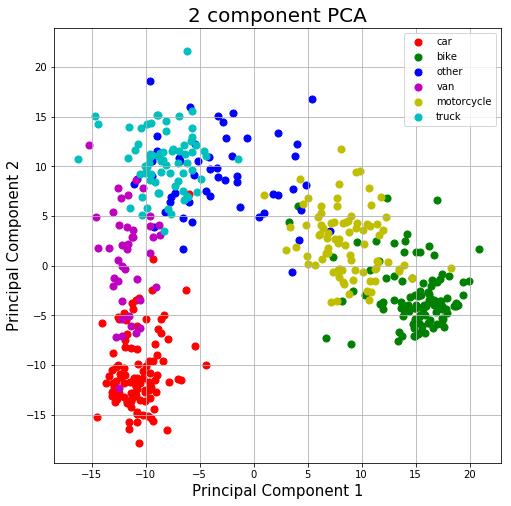

In [17]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
unique_targets = final_df.target.unique()
colors = ['r', 'g', 'b', 'm', 'y', 'c']
for target, color in zip(unique_targets,colors):
    indicesToKeep = final_df['target'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               , final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(unique_targets)
ax.grid()

## 4. Visual Search with k-NN

The goal of this part is to implement an image search based on unsupervised k-NN. In order to find the optimal number of neighbors, a supervised k-NN model is trained.

In [18]:
# X data
# ------
X_train = features[features[:,-1] == 1,:]
X_train = np.delete(X_train, -1, axis=1)

X_valid = features[features[:,-1] == 2,:]
X_valid = np.delete(X_valid, -1, axis=1)

X_test = features[features[:,-1] == 3,:]
X_test = np.delete(X_test, -1, axis=1);

# y data
# ------
y_train = targets[0:X_train.shape[0]]
y_valid = targets[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]]
y_test = targets[X_train.shape[0]+X_valid.shape[0]:]

In [19]:
neigh = KNeighborsClassifier(n_neighbors=10)
knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', neigh)])
knn_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform'))])

*This step takes some time. You can set the cell to code if you want to run the cell.*

In [20]:
knn_supervised_cv = joblib.load('knn_supervised.pkl')
knn_supervised_cv.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('knn',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=None, n_neighbors=3, p=1,
              weights='uniform'))],
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=3, p=1,
            weights='uniform'),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 3,
 'knn__p': 1,
 'knn__weights': 'uniform'}

In [21]:
knn_supervised = knn_supervised_cv.named_steps['knn']

In [22]:
paths_all = [p for sublist in file_names_dict.values() for p in sublist]
paths_train = [p for p in paths_all if 'train' in p]
paths_test = [p for  p in paths_all if 'test' in p]
paths_test[0:5]

['test/car/car-0097.png',
 'test/car/car-0103.png',
 'test/car/car-0102.png',
 'test/car/car-0100.png',
 'test/car/car-0101.png']

In [23]:
knn_unsupervised = NearestNeighbors()
knn_unsupervised.fit(X_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [24]:
knn_unsupervised.set_params(n_neighbors=knn_supervised.n_neighbors)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=3, p=2, radius=1.0)

In [25]:
def search_kneighbors(idx, paths_train, paths_test, X_train, X_test, k, knn_model, return_val=False):
    
    """
    This function prints the test image and the k nearest neighbors.
    
    args:
        idx: index, representing the image to choose from the test set.
        paths_train: paths of the training set
        paths_test: paths of the test set
        X_train: training data
        X_test: test data
        k: the number of nearest neighbors to be printed
        knn_model: nearest neighbor
        return_val: True: returns a tuple with the indices and the distances. False: None.
                    Default False.
    
    returns:
        a tuple with the indices and the distances if indicated.
    
    """
        
    # Find the k nearest neighbors
    # ----------------------------
    distances, indices = knn_model.kneighbors(X_test[idx,:].reshape(1,-1), n_neighbors=k)
    
    distances = distances[0]
    indices = indices[0]
    
    # Extract the paths of the k nearest neighbors
    # --------------------------------------------
    path_neighbors = [p for i, p in enumerate(paths_train) if i in indices]
    
    # Plot the images
    # ---------------
    plt.figure(figsize=(15,15))
    
    for i in range(k+1):
        plt.subplot(1, k+1, i+1)
        plt.subplots_adjust(right=1)
        
        if i == 0:
            path = paths_test[idx]
        else:
            path = path_neighbors[i-1]
            
        #print(path)
        img = load_image(path)
        
        #print('Batch size:', img.shape) # (1, 224, 224, 3)
        plt.imshow(img[0,:,:,:])
        plt.axis('off')
        if i == 0:
            plt.title('test image')
        else:
            plt.title("d: {0:5.2f}".format(distances[i-1]))
            
    if return_val == True:      
        return(indices, distances)

# Example
# -------
#k = 10
#knn_model = knn_unsupervised
#search_kneighbors(9, paths_train, paths_test, X_train, X_test, k, knn_model)    

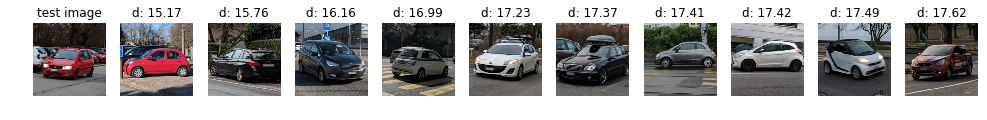

In [26]:
k = 10
knn_model = knn_unsupervised
search_kneighbors(9, paths_train, paths_test, X_train, X_test, k, knn_model) 

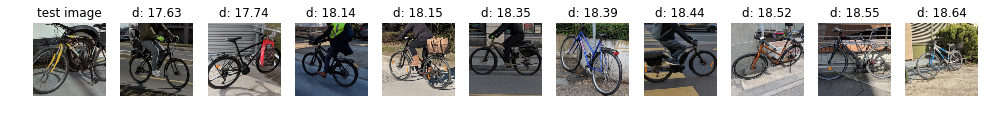

In [27]:
k = 10
knn_model = knn_unsupervised
search_kneighbors(20, paths_train, paths_test, X_train, X_test, k, knn_model) 